# Spark Arrow compression test 
In this section, we use spark and arrow to output parquet files with different compression algo.

In [1]:
from pyspark.sql import SparkSession,DataFrame
import os
import numpy as np
from pyspark.sql import functions as f
from pyspark.sql.types import *
import io
import time
from pyspark.sql import Row


In [4]:
local=True
# spark.rpc.message.maxSize if for write large csv file. The default value is 128, here we set it to 1024
if local:
    spark = SparkSession \
    .builder.master("local[4]") \
    .appName("SparkArrowCompression") \
    .getOrCreate()
else: 
    spark = SparkSession \
    .builder.master("k8s://https://kubernetes.default.svc:443") \
    .appName("SparkArrowCompression") \
    .config("spark.kubernetes.container.image", "inseefrlab/jupyter-datascience:master") \
    .config("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT']) \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.memory","8g") \
    .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE']) \
    .getOrCreate()

In [3]:
spark.sparkContext.stop()

In [4]:
! kubectl get pods

I0928 08:32:08.076453     891 request.go:655] Throttling request took 1.172859018s, request: GET:https://kubernetes.default/apis/certificates.k8s.io/v1beta1?timeout=32s
NAME                                            READY   STATUS        RESTARTS   AGE
flume-test-agent-df8c5b944-vtjbx                1/1     Running       0          8d
jupyter-14458-56c69685d-pshm9                   1/1     Running       0          25h
jupyter-266220-5bf4b859f8-wfkz6                 1/1     Running       0          58m
kafka-server-0                                  1/1     Running       0          8d
kafka-server-1                                  1/1     Running       0          8d
kafka-server-2                                  1/1     Running       0          8d
kafka-server-zookeeper-0                        1/1     Running       0          8d
sparkarrowcompression-4a9eae7c2b881a56-exec-2   0/1     Terminating   0          17s
sparkarrowcompression-4a9eae7c2b881a56-exec-4   0/1     Terminating   0

In [40]:
! kubectl get pods | grep Error | awk '{print $1}' | xargs kubectl delete pods

I0927 11:02:42.595871    1302 request.go:655] Throttling request took 1.171717446s, request: GET:https://kubernetes.default/apis/admissionregistration.k8s.io/v1beta1?timeout=32s
I0927 11:02:46.336856    1334 request.go:655] Throttling request took 1.169242263s, request: GET:https://kubernetes.default/apis/admissionregistration.k8s.io/v1beta1?timeout=32s
pod "sparkarrowcompression-54e6b27c17dae4b3-exec-1" deleted
pod "sparkarrowcompression-54e6b27c17dae4b3-exec-2" deleted
pod "sparkarrowcompression-54e6b27c17dae4b3-exec-3" deleted
pod "sparkarrowcompression-54e6b27c17dae4b3-exec-4" deleted


In [5]:
parquet_input_path = "s3a://pengfei/diffusion/data_format/sf_fire/parquet/raw"
compress_output_path = "s3a://pengfei/diffusion/data_format/sf_fire/parquet"
output_path="s3a://pengfei/diffusion/data_format/spark_netflix/"
csv_input_path="s3a://pengfei/diffusion/data_format/ny_taxis/csv"

In [52]:
fireSchema = StructType([StructField('CallNumber', IntegerType(), True),
                     StructField('UnitID', StringType(), True),
                     StructField('IncidentNumber', IntegerType(), True),
                     StructField('CallType', StringType(), True),                  
                     StructField('CallDate', StringType(), True),       
                     StructField('WatchDate', StringType(), True),       
                     StructField('ReceivedDtTm', StringType(), True),       
                     StructField('EntryDtTm', StringType(), True),       
                     StructField('DispatchDtTm', StringType(), True),       
                     StructField('ResponseDtTm', StringType(), True),       
                     StructField('OnSceneDtTm', StringType(), True),       
                     StructField('TransportDtTm', StringType(), True),                  
                     StructField('HospitalDtTm', StringType(), True),       
                     StructField('CallFinalDisposition', StringType(), True),       
                     StructField('AvailableDtTm', StringType(), True),       
                     StructField('Address', StringType(), True),       
                     StructField('City', StringType(), True),       
                     StructField('ZipcodeofIncident', IntegerType(), True),       
                     StructField('Battalion', StringType(), True),                 
                     StructField('StationArea', StringType(), True),       
                     StructField('Box', StringType(), True),       
                     StructField('OriginalPriority', StringType(), True),       
                     StructField('Priority', StringType(), True),       
                     StructField('FinalPriority', IntegerType(), True),       
                     StructField('ALSUnit', BooleanType(), True),       
                     StructField('CallTypeGroup', StringType(), True),
                     StructField('NumberofAlarms', IntegerType(), True),
                     StructField('UnitType', StringType(), True),
                     StructField('Unitsequenceincalldispatch', IntegerType(), True),
                     StructField('FirePreventionDistrict', StringType(), True),
                     StructField('SupervisorDistrict', StringType(), True),
                     StructField('NeighborhoodDistrict', StringType(), True),
                     StructField('Location', StringType(), True),
                     StructField('RowID', StringType(), True)])
data_path="s3a://pengfei/diffusion/data_format/Fire_Department_Calls_for_Service.csv"
df = spark.read.options(delimiter=',').option("header","true").schema(fireSchema).csv(data_path)
print(df.columns)
df.show(1)
df.printSchema()



['CallNumber', 'UnitID', 'IncidentNumber', 'CallType', 'CallDate', 'WatchDate', 'ReceivedDtTm', 'EntryDtTm', 'DispatchDtTm', 'ResponseDtTm', 'OnSceneDtTm', 'TransportDtTm', 'HospitalDtTm', 'CallFinalDisposition', 'AvailableDtTm', 'Address', 'City', 'ZipcodeofIncident', 'Battalion', 'StationArea', 'Box', 'OriginalPriority', 'Priority', 'FinalPriority', 'ALSUnit', 'CallTypeGroup', 'NumberofAlarms', 'UnitType', 'Unitsequenceincalldispatch', 'FirePreventionDistrict', 'SupervisorDistrict', 'NeighborhoodDistrict', 'Location', 'RowID']
+----------+------+--------------+--------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------------+--------------------+--------------------+--------------------+-------------+-----------------+---------+-----------+----+----------------+--------+-------------+-------+-------------+--------------+--------+--------------------------+----------------------+----------

In [6]:
def check_spark_parquet_read_time(path:str)->DataFrame:
    t1=time.time()
    df=spark.read.parquet(path)
    print(f"data frame has {df.count()} rows, {len(df.columns)} columns")
    t2=time.time()
    print(f"Spark read above data frame in parquet format, and spents: {t2 - t1} s")
    return df

# read parquet generated by arrow    
df=check_spark_parquet_read_time(parquet_input_path)

# df.printSchema()

# read parquet generated by spark
# check_spark_parquet_read_time("s3a://pengfei/diffusion/data_format/netflix.parquet")

data frame has 5500519 rows, 34 columns
Spark read above data frame in parquet format, and spents: 7.415986061096191 s


In [7]:
def check_spark_csv_write_time(df:DataFrame,path:str):
    t1=time.time()
    df.coalesce(1).write.option("header","true").csv(path)
    print(f"data frame has {df.count()} rows, {len(df.columns)} columns")
    t2=time.time()
    print(f"Spark read time spents: {t2 - t1} s")

# check_spark_csv_write_time(df,f"{csv_input_path}/2011_2012")   

def check_spark_csv_read_time(path):
    t1=time.time()
    df=spark.read.csv(path)
    print(f"data frame has {df.count()} rows, {len(df.columns)} columns")
    t2=time.time()
    print(f"Spark read time spents: {t2 - t1} s")
    return df

# df_fire=check_spark_read_csv_time(csv_example)


In [8]:
def check_spark_parquet_write_time(df,path,partition_number,compression_algo):
    t1=time.time()
    df.coalesce(partition_number).write \
    .option("parquet.compression",compression_algo) \
    .parquet(path) 
    t2=time.time()
    print(f"Spark write parquet with {compression_algo} compression, it spents : {t2 - t1} s")
 

# 1. Spark compression example

# 1.1 Spark Compress with gzip

In [55]:
# Spark write parquet with gzip compression ny 2009, it spents : 327.7600781917572 s

comp_algo="gzip"
check_spark_parquet_write_time(df,f"{compress_output_path}/spark_sf_fire_{comp_algo}",4,comp_algo)


Spark write parquet with gzip compression, it spents : 74.42315220832825 s


In [25]:
! mc ls --summarize s3/pengfei/diffusion/data_format/sf_fire/parquet/spark_sf_fire_gzip | grep "Total Size"

Total Size: 355 MiB


## 1.2 Spark compress with snappy

In [56]:
#Spark write parquet with snappy compression ny 2009, it spents : 210.80829095840454 s

comp_algo="snappy"
check_spark_parquet_write_time(df,f"{compress_output_path}/spark_sf_fire_{comp_algo}",4,comp_algo)


Spark write parquet with snappy compression, it spents : 50.436259031295776 s


In [57]:
! mc ls --summarize s3/pengfei/diffusion/data_format/sf_fire/parquet/spark_sf_fire_snappy | grep "Total Size"

Total Size: 552 MiB


## 1.3 Spark Compress with lz4
missing lz4 dependencies, but the doc says it's supported by default 
https://spark.apache.org/docs/latest/sql-data-sources-parquet.html

In [ ]:
comp_algo="lz4"
check_spark_parquet_write_time(df,f"{compress_output_path}/spark_sf_fire_{comp_algo}",4,comp_algo)

## 1.4 Spark compress with lzo
missing lzo dependencies, but the doc says it's supported by default 
https://spark.apache.org/docs/latest/sql-data-sources-parquet.html

In [ ]:
comp_algo="lzo"
check_spark_parquet_write_time(df,f"{compress_output_path}/spark_sf_fire_{comp_algo}",4,comp_algo)

## 1.5 Spark compress with brotli
doc says it's not supported by default, so missing brotli dependencies is normal

In [ ]:
comp_algo="brotli"
check_spark_parquet_write_time(df,f"{compress_output_path}/spark_sf_fire_{comp_algo}",4,comp_algo)

## 1.6 Spark compress with zstd
doc says it's not supported by default, so missing zstd dependencies is normal

In [ ]:
# zstd is not supported by default
comp_algo="zstd"
check_spark_parquet_write_time(df,f"{compress_output_path}/spark_sf_fire_{comp_algo}",4,comp_algo)

## 1.7 Spark compress with none

In [83]:
# zstd is not supported by default
comp_algo="none"
check_spark_parquet_write_time(df,f"{compress_output_path}/spark_sf_fire_{comp_algo}",4,comp_algo)

Spark write parquet with none compression, it spents : 41.00978446006775 s


In [84]:
! mc ls --summarize s3/pengfei/diffusion/data_format/sf_fire/parquet/spark_sf_fire_none | grep "Total Size"

Total Size: 1.1 GiB


## Pyarrow writes parquet with compression


In [9]:
import pathlib
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import s3fs
import os
import time

In [2]:
# This function reads a parquet data set (partitioned partque files) from s3, and returns an arrow table
def read_parquet_from_s3(endpoint: str, bucket_name, path):
    url = f"https://{endpoint}"
    fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': url})
    file_uri = f"{bucket_name}/{path}"
    str_info = fs.info(file_uri)
    print(f"input file metadata: {str_info}")
    dataset = pq.ParquetDataset(file_uri, filesystem=fs, metadata_nthreads=8)
    table = dataset.read()
    return table

# check read time
def check_arrow_read_time(endpoint, bucket, path):
    t1 = time.time()
    arrow_table=read_parquet_from_s3(endpoint, bucket, path)
    t2 = time.time()
    print(f"Arrow read time spents: {t2 - t1} s")
    get_shape(arrow_table)
    return arrow_table
    
# This function reads an arrow table, convert it to a pandas dataframe, then return the shape of the dataframe. 
def get_shape(table):
    df = table.to_pandas()
    print(f"shape of the data set: {df.shape}")

In [3]:
endpoint = os.environ['AWS_S3_ENDPOINT']
bucket = "pengfei"
# don't add / after raw, it will raise error
input_path = "diffusion/data_format/sf_fire/parquet/raw"

In [4]:
arrow_table=check_arrow_read_time(endpoint,bucket, input_path)

input file metadata: {'Key': 'pengfei/diffusion/data_format/sf_fire/parquet/raw', 'name': 'pengfei/diffusion/data_format/sf_fire/parquet/raw', 'type': 'directory', 'Size': 0, 'size': 0, 'StorageClass': 'DIRECTORY'}
Arrow read time spents: 7.463285446166992 s
shape of the data set: (5500519, 34)


In [5]:
pdf=arrow_table.to_pandas()
print(pdf.head(2))

   CallNumber UnitID  IncidentNumber CallType    CallDate   WatchDate  \
0   210391607    E19        21017645   Alarms  02/08/2021  02/08/2021   
1   210391164    T04        21017596   Alarms  02/08/2021  02/08/2021   

             ReceivedDtTm               EntryDtTm            DispatchDtTm  \
0  02/08/2021 01:00:14 PM  02/08/2021 01:01:36 PM  02/08/2021 01:01:40 PM   
1  02/08/2021 10:54:56 AM  02/08/2021 10:56:50 AM  02/08/2021 10:56:57 AM   

             ResponseDtTm  ... ALSUnit CallTypeGroup NumberofAlarms UnitType  \
0  02/08/2021 01:03:21 PM  ...    True         Alarm              1   ENGINE   
1  02/08/2021 10:57:07 AM  ...   False         Alarm              1    TRUCK   

  Unitsequenceincalldispatch FirePreventionDistrict SupervisorDistrict  \
0                        1.0                      8                  7   
1                        1.0                      3                  6   

   NeighborhoodDistrict       Location  \
0             Lakeshore  210391607-E19   


In [9]:
# This function write an arrow table to s3 as parquet files, you can specify a compression type
# compression (str or dict) – Specify the compression codec, either on a general basis or per-column. 
# Valid values: {‘NONE’, ‘SNAPPY’, ‘GZIP’, ‘BROTLI’, ‘LZ4’, ‘ZSTD’}.
# default is snappy.

def write_parquet_as_partitioned_dataset(table, endpoint, bucket_name, path, partition_cols=None, compression="SNAPPY"):
    url = f"https://{endpoint}"
    fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': url})
    file_uri = f"{bucket_name}/{path}"
    pq.write_to_dataset(table, root_path=file_uri, partition_cols=partition_cols, filesystem=fs, compression=compression)
    
# check write time
def check_write_time(table, endpoint, bucket_name, path, partition_cols=None, compression="SNAPPY"):
    t1=time.time()
    write_parquet_as_partitioned_dataset(table, endpoint, bucket_name, path, partition_cols,compression=compression)
    t2=time.time()
    print(f"Arrow write time spents: {t2 - t1} s")

In [11]:
output_path=f"diffusion/data_format/sf_fire/parquet/arrow_sf_fire_snappy"
check_write_time(arrow_table,endpoint,bucket,output_path)

Arrow write time spents: 37.47578525543213 s


In [10]:
! mc ls --summarize s3/pengfei/diffusion/data_format/sf_fire/parquet/arrow_sf_fire_snappy | grep "Total Size"

Total Size: 596 MiB


In [12]:
output_path="diffusion/data_format/sf_fire/parquet/arrow_sf_fire_zstd"
check_write_time(arrow_table,endpoint,bucket,output_path,compression="ZSTD")

Arrow write time spents: 29.63837957382202 s


In [13]:
! mc ls --summarize s3/pengfei/diffusion/data_format/sf_fire/parquet/arrow_sf_fire_zstd | grep "Total Size"

Total Size: 385 MiB


In [14]:
output_path="diffusion/data_format/sf_fire/parquet/arrow_sf_fire_gzip"
check_write_time(arrow_table,endpoint,bucket,output_path,compression="GZIP")

Arrow write time spents: 138.10498523712158 s


In [15]:
! mc ls --summarize s3/pengfei/diffusion/data_format/sf_fire/parquet/arrow_sf_fire_gzip | grep "Total Size"

Total Size: 372 MiB


In [16]:
output_path="diffusion/data_format/sf_fire/parquet/arrow_sf_fire_lz4"
check_write_time(arrow_table,endpoint,bucket,output_path,compression="LZ4")

Arrow write time spents: 38.89105200767517 s


In [17]:
! mc ls --summarize s3/pengfei/diffusion/data_format/sf_fire/parquet/arrow_sf_fire_lz4 | grep "Total Size"

Total Size: 589 MiB


In [8]:
output_path="diffusion/data_format/sf_fire/parquet/arrow_sf_fire_brotli"
check_write_time(arrow_table,endpoint,bucket,output_path,compression="BROTLI")

Arrow write time spents: 163.5519528388977 s


In [9]:
! mc ls --summarize s3/pengfei/diffusion/data_format/sf_fire/parquet/arrow_sf_fire_brotli | grep "Total Size"

Total Size: 332 MiB


In [10]:
output_path="diffusion/data_format/sf_fire/parquet/arrow_sf_fire_none"
check_write_time(arrow_table,endpoint,bucket,output_path,compression="NONE")

Arrow write time spents: 72.52444410324097 s


In [11]:
! mc ls --summarize s3/pengfei/diffusion/data_format/sf_fire/parquet/arrow_sf_fire_none | grep "Total Size"

Total Size: 1.3 GiB


## Overall time lantency and size comparison

You can reproduce the pyarrow and spark stats inside this notebook. To reproduce the R arrow stats, you can use this https://raw.githubusercontent.com/pengfei99/ParquetPyArrow/main/R/ArrowCompression.Rmd   

In [17]:
# Spark, Arrow compression performence comparession
path="s3a://pengfei/diffusion/data_format/compression_stats.csv"
stats_df=spark.read.option("header","true").csv(path)
stats_df.show()

# The raw CSV file takes 1918 MiB to store the same data.

+---------+----------------+----------------+----+
|framework|compression_type|compression_time|size|
+---------+----------------+----------------+----+
|  pyarrow|            none|           72.52|1312|
|  pyarrow|          brotli|          163.55| 332|
|  pyarrow|             lz4|           38.89| 589|
|  pyarrow|            gzip|          138.10| 372|
|    spark|            gzip|           74.42| 355|
|    spark|          snappy|           50.43| 552|
|  pyarrow|            zstd|           29.63| 385|
|  pyarrow|          snappy|           37.47| 596|
|    spark|            none|              41|1129|
|   Rarrow|            none|           59.06|1318|
|   Rarrow|          snappy|           55.43| 596|
|   Rarrow|            gzip|          123.14| 372|
|   Rarrow|             lz4|           54.88| 589|
|   Rarrow|            zstd|           52.78| 385|
|   Rarrow|          brotli|          132.65| 332|
+---------+----------------+----------------+----+



Text(0, 0.5, 'Size (MiB)')

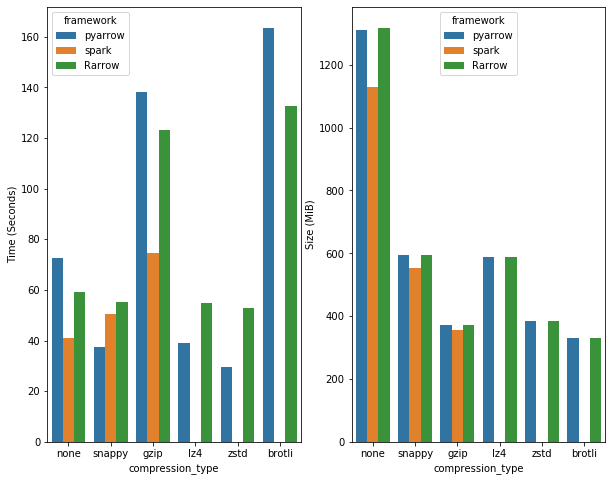

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize = (10,8))
g_op = sns.barplot(
    data=stats_df.toPandas(),
    x="compression_type", y="compression_time", hue="framework",
    order=['none','snappy','gzip','lz4','zstd','brotli'], ax=ax[0]
)
g_op.set_ylabel("Time (Seconds)", fontsize = 10)

g_op = sns.barplot(
    data=stats_df.toPandas(),
    x="compression_type", y="size", hue="framework",
    order=['none','snappy','gzip','lz4','zstd','brotli'], ax=ax[1]
)
g_op.set_ylabel("Size (MiB)", fontsize = 10)

# Arrow compression and dictionary encoding by column
Arrow allows us to specify compression and dictionary codec per column when write to a parquet file
spark does not, spark can only specify a global compression and dicionary codec for all columns.

pq.write_table(table, where, compression={'foo': 'snappy', 'bar': 'gzip'}, use_dictionary=['foo', 'bar'])

# Spark read mix compression, 

Below test proves that spark can read correctly parquet files that has mixed compression algorithm.


In [10]:
url = f"https://{endpoint}"
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': url})
path="diffusion/data_format/sf_fire/parquet/arrow_mix_compression"
file_uri = f"{bucket}/{path}"
pq.write_table(arrow_table, file_uri, filesystem=fs, compression={"UnitID":"SNAPPY","NumberofAlarms":"GZIP"})

In [18]:
path="s3a://pengfei/diffusion/data_format/sf_fire/parquet/arrow_mix_compression"
df=check_spark_parquet_read_time(path)

data frame has 5500519 rows, 34 columns
Spark read above data frame in parquet format, and spents: 1.7260215282440186 s


In [20]:
df.show(2)

+----------+------+--------------+--------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------------+--------------------+--------------------+--------------------+-------------+-----------------+---------+-----------+----+----------------+--------+-------------+-------+-------------+--------------+--------+--------------------------+----------------------+------------------+--------------------+-------------+--------------------+
|CallNumber|UnitID|IncidentNumber|CallType|  CallDate| WatchDate|        ReceivedDtTm|           EntryDtTm|        DispatchDtTm|        ResponseDtTm|         OnSceneDtTm|TransportDtTm|HospitalDtTm|CallFinalDisposition|       AvailableDtTm|             Address|         City|ZipcodeofIncident|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumberofAlarms|UnitType|Unitsequenceincalldispatch|FirePreventionDistrict|SupervisorDist

In [19]:
print(df.columns)

['CallNumber', 'UnitID', 'IncidentNumber', 'CallType', 'CallDate', 'WatchDate', 'ReceivedDtTm', 'EntryDtTm', 'DispatchDtTm', 'ResponseDtTm', 'OnSceneDtTm', 'TransportDtTm', 'HospitalDtTm', 'CallFinalDisposition', 'AvailableDtTm', 'Address', 'City', 'ZipcodeofIncident', 'Battalion', 'StationArea', 'Box', 'OriginalPriority', 'Priority', 'FinalPriority', 'ALSUnit', 'CallTypeGroup', 'NumberofAlarms', 'UnitType', 'Unitsequenceincalldispatch', 'FirePreventionDistrict', 'SupervisorDistrict', 'NeighborhoodDistrict', 'Location', 'RowID']


# Check spark read zstd failed
The check failed, our spark does not have the zstd lib installed

In [ ]:
path="s3a://pengfei/diffusion/data_format/sf_fire/parquet/arrow_sf_fire_zstd"
df=check_spark_parquet_read_time(path)
df.show()

# Check spark read brotli failed
The check failed, our spark does not have the brotli lib installed

In [ ]:
path="s3a://pengfei/diffusion/data_format/sf_fire/parquet/arrow_sf_fire_brotli"
df=check_spark_parquet_read_time(path)
df.show()

# Check spark read lz4 failed
The check failed, our spark does not have the lz4 lib installed

In [ ]:
path="s3a://pengfei/diffusion/data_format/sf_fire/parquet/arrow_sf_fire_lz4"
df=check_spark_parquet_read_time(path)
df.show()

# Pyarrow Read parquet file generated by spark 

In [32]:
spark_parquet_path1 = "diffusion/data_format/sf_fire/parquet/spark_sf_fire_gzip"
spark_parquet_path2 = "diffusion/data_format/sf_fire/parquet/spark_sf_fire_snappy"
spark_parquet_path3 = "/home/jovyan/work/spark_sf_fire_gzip/part-00000-a908eedc-847b-45e2-803a-6c4a07438b4a-c000.gz.parquet"

## Arrow read spark gzip

In [35]:
table1=check_arrow_read_time(endpoint,bucket, spark_parquet_path1)

input file metadata: {'name': 'pengfei/diffusion/data_format/sf_fire/parquet/spark_sf_fire_gzip', 'size': 0, 'type': 'directory'}
Arrow read time spents: 7.748699426651001 s
shape of the data set: (5500519, 34)


## Arrow read spark snappy

In [34]:
table2=check_arrow_read_time(endpoint,bucket, spark_parquet_path2)

input file metadata: {'name': 'pengfei/diffusion/data_format/sf_fire/parquet/spark_sf_fire_snappy', 'size': 0, 'type': 'directory'}
Arrow read time spents: 11.924895763397217 s
shape of the data set: (5500519, 34)


# Check default parquet format version generated by spark 

In [27]:
def get_metadata(path: str):
    metadata=pq.read_metadata(path)
    # get the metadata of the parquet file
    print(f"General metadata: {metadata} \n")
    # get the metadata of the row group 0
    print(f"Metadata of row group 0: {metadata.row_group(0)}\n")
    # get the metadata of the column 0 of row group 0
    print(f"Metadata of column 0 of row group 0: {metadata.row_group(0).column(0)}")


In [28]:
# in below metadata, we get the parquet format version is 1.0.
# So by default, spark write parquet in version 1.0
get_metadata(spark_parquet_path2)

General metadata: <pyarrow._parquet.FileMetaData object at 0x7f9aa0454fb0>
  created_by: parquet-mr version 1.10.1 (build a89df8f9932b6ef6633d06069e50c9b7970bebd1)
  num_columns: 34
  num_rows: 1486336
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 6810 

Metadata of row group 0: <pyarrow._parquet.RowGroupMetaData object at 0x7f9aa0456230>
  num_columns: 34
  num_rows: 1486336
  total_byte_size: 356445213

Metadata of column 0 of row group 0: <pyarrow._parquet.ColumnChunkMetaData object at 0x7f9aa0456290>
  file_offset: 4
  file_path: 
  physical_type: INT32
  num_values: 1486336
  path_in_schema: CallNumber
  is_stats_set: True
  statistics:
      has_min_max: True
      min: 1030101
      max: 210630242
      null_count: 0
      distinct_count: 0
      num_values: 1486336
      physical_type: INT32
      logical_type: None
      converted_type (legacy): NONE
  compression: GZIP
  encodings: ('PLAIN', 'RLE', 'BIT_PACKED')
  has_dictionary_page: False
  dictionary_page_of